In [5]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
#from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

## Utility functions


In [6]:
def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
        
        
##
## This function reutrn a list of matrices. Each matrix correspond to a question instance in which each row is a channel, and in the coloumn it develop the signal in time
## The function also manage to standardize the time length
def channels_to_vector(channels): 
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


##
# Create the train data matrix
##
## usage
def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


### Description
def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
## description
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix


def classification_SVM_experiments(X, Y, clf_parameters, fraction_train_test, num_experiments):
    
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    dataset_length=X.shape[0];
    
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        train =X[i1,:]
        labels_train=Y[i1]
        
        test = X[i2,:]
        labels_test=Y[i2]
        
        #SVM classificator definition
        C_best = clf_parameters['C']
        gamma_best = clf_parameters['gamma']
        kernel_best = clf_parameters['kernel']
        
        clf = svm.SVC(C = C_best, kernel = kernel_best, gamma = gamma_best, random_state = single_seed)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        #print(test.shape)
        #print(labels_test.shape)
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train

def performance_assesment_fraction(X, Y, num_experiment, clf_parameters):
    fracs = np.linspace(0.2,0.9,25)
    accuracy_test_mean  = []
    accuracy_test_std   = []
    accuracy_train_mean = []
    accuracy_train_std  = []

    for frac_tr_te in fracs:
        print("Evaluation progress: " + str(int((frac_tr_te-fracs[0])/(fracs[-1]-fracs[0])*100)) + " %")
        acc_test, acc_train = classification_SVM_experiments(X, Y, clf_parameters, frac_tr_te, num_experiment)
        #saving of metrics of interest
        accuracy_test_mean.append(np.mean(acc_test))
        accuracy_test_std.append(np.std(acc_test))
        accuracy_train_mean.append(np.mean(acc_train))
        accuracy_train_std.append(np.std(acc_train))

    plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
    plt.title('SVM perfomances over different train/test dataset')
    plt.ylabel('Accuracy')
    plt.xlabel('Train/test fraction')
    plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
    plt.savefig('train_test_acc', format='pdf')
    plt.show()

    
def leave_one_out(X, Y, clf_parameters):
    svm_total_acc_test = []
    for i in range(60):
#SVM classifier definition
        i1 = [j for j in range(60)]
        i1.remove(i)
        i2 = i
        train=X[i1,:]
        labels_train=Y[i1]

        test= X[i2,:]
        labels_test=Y[i2]
        #print(i1)
        #print(i2)
        C_best = clf_parameters['C']
        gamma_best = clf_parameters['gamma']
        kernel_best = clf_parameters['kernel']
        
        clf_temp = svm.SVC(C = C_best, kernel = kernel_best, gamma = gamma_best)
        #SVM fit on train data
        clf_temp.fit(train, labels_train)  

        #Accuracy on test
        predicted_labels_test = clf_temp.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))

# EEG feature loading
Import data from previous analysis

In [7]:
#Import data from mat files
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')

channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

#Features Loading
features_extracted_yes   = sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no    = sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes = sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no  = sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']

channels_structure_yes_EEG = channels_to_vector(channels_yes_EEG)
channels_structure_no_EEG  = channels_to_vector(channels_no_EEG)

##Structuring of the data:
#the code below create the train matrix with respect to the signal given in "channel_structure" but using the features contained in "features_extracted*" and in "connettivity_feature*".
feature_dataset_yes_EEG, EEG_yes_labels = get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

feature_dataset_no_EEG, EEG_no_labels = get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);

#Merge the labeled data
feature_dataset_full = np.concatenate((feature_dataset_yes_EEG, feature_dataset_no_EEG), axis=0 )
labels = np.concatenate((EEG_yes_labels,EEG_no_labels), axis=0)


print("The dataset have shape:")
print(feature_dataset_full.shape)

The dataset have shape:
(60, 386)


## Feature selection

In [8]:
##Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#feature_dataset_full
reducer = SelectKBest(f_classif, k=92)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)


idxs = []
for k in range(92):
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    boolean_vec = reducer.get_support()
    idx = []
    for i in range(len(boolean_vec)):
        if boolean_vec[i] == True: idx.append(i)
    idxs.append(idx)
    
best_feat_idx_ordered = []
for i in range(len(idxs)):
    for j in range(len(idxs[i])):
        a = idxs[i]
        if a[j] not in best_feat_idx_ordered: best_feat_idx_ordered.append(a[j])
print("best features ordered for decreasing importance")
print(best_feat_idx_ordered)

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


best features ordered for decreasing importance
[292, 288, 169, 115, 320, 165, 287, 304, 173, 244, 67, 192, 66, 276, 71, 272, 256, 262, 260, 291, 82, 70, 161, 218, 213, 139, 193, 120, 228, 240, 106, 122, 14, 110, 45, 340, 214, 201, 143, 217, 284, 248, 18, 46, 158, 312, 354, 263, 74, 11, 136, 236, 119, 128, 316, 118, 93, 358, 39, 58, 22, 92, 224, 336, 29, 189, 164, 97, 212, 26, 78, 172, 230, 35, 51, 96, 3, 168, 88, 83, 55, 101, 216, 40, 134, 62, 111, 7, 247, 369, 368]


## Hyperparameters selection


In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import svm
import time

reducer = SelectKBest(f_classif, k=15)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

punti = 10
parameters = {'kernel':['rbf','linear'], 'C':np.logspace(-4,3,punti), 'gamma' : np.logspace(-4,3,punti)}


X_train, X_test, y_train, y_test = train_test_split(
    feature_dataset_reduced, labels, test_size=0.5, random_state=0)


svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv = 6, n_jobs = 1)

bef =  time.time()
clf.fit(X_train, y_train)
now = time.time()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Evaluation time: " + str(now-bef))


def score_multiple(model, X, y):
    num_exp = 10
    for i in np.floor(np.random.rand(num_exp)*100):
        1==1
        

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Best parameters set found on development set:

{'C': 0.774263682681127, 'gamma': 0.0001, 'kernel': 'linear'}

Evaluation time: 3.146653890609741


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Evaluation progress: 0 %
Evaluation progress: 4 %
Evaluation progress: 8 %
Evaluation progress: 12 %
Evaluation progress: 16 %
Evaluation progress: 20 %
Evaluation progress: 25 %
Evaluation progress: 29 %
Evaluation progress: 33 %
Evaluation progress: 37 %
Evaluation progress: 41 %
Evaluation progress: 45 %
Evaluation progress: 50 %
Evaluation progress: 54 %
Evaluation progress: 58 %
Evaluation progress: 62 %
Evaluation progress: 66 %
Evaluation progress: 70 %
Evaluation progress: 74 %
Evaluation progress: 79 %
Evaluation progress: 83 %
Evaluation progress: 87 %
Evaluation progress: 91 %
Evaluation progress: 95 %
Evaluation progress: 100 %


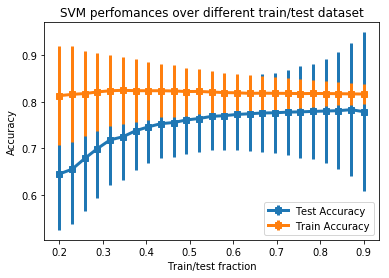

In [114]:
para = {'C': 1e8, 'gamma': 'auto', 'kernel': 'linear'}
reducer = SelectKBest(f_classif, k=15)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)
performance_assesment_fraction(feature_dataset_reduced, labels, 2000, clf.best_params_)

In [122]:
bef = time.time()
res = leave_one_out(feature_dataset_reduced, labels, clf.best_params_)
print(time.time()-bef)
print(res)

0.1470332145690918
0.8833333333333333


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

In [123]:
def findHyper(k):
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    punti = 10
    parameters = {'kernel':['rbf','linear'], 'C':np.logspace(-4,3,punti), 'gamma' : np.logspace(-4,3,punti)}


    X_train, X_test, y_train, y_test = train_test_split(
        feature_dataset_reduced, labels, test_size=0.5, random_state=0)


    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv = 6, n_jobs = 1)

    bef =  time.time()
    clf.fit(X_train, y_train)
    now = time.time()
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    performances = leave_one_out(feature_dataset_reduced, labels, clf.best_params_)
    return [performances, clf.best_params_]
    
    

In [128]:
perf_vec = []
para_vec = []
range_k = range(15,100)
for k in range_k:
    [perf, para] = findHyper(k)
    perf_vec.append(perf)
    para_vec.append(para)
best_k = range_k[np.argmax(perf)]
print(best_k)
print(perf_vec[best_k])

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Best parameters set found on development set:

{'C': 0.774263682681127, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 4.641588833612782, 'gamma': 0.1291549665014884, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 4.641588833612782, 'gamma': 0.1291549665014884, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 4.641588833612782, 'gamma': 0.1291549665014884, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 4.641588833612782, 'gamma': 0.1291549665014884, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 4.641588833612782, 'gamma': 0.1291549665014884, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.774263682681127, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 1000.0, 'gamma': 0.0001, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 166.81005372000593, 'gamma': 0.0001, 'kernel': 'rbf'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.774263682681127, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.774263682681127, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.1291549665014884, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.003593813663804626, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}



/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

Best parameters set found on development set:

{'C': 0.0005994842503189409, 'gamma': 0.0001, 'kernel': 'linear'}

15
0.8833333333333333


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

In [129]:
print(best_k)
print(perf_vec[best_k])

15
0.8833333333333333


In [132]:
print(perf_vec)

[0.8833333333333333, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.9166666666666666, 0.8333333333333334, 0.8833333333333333, 0.9166666666666666, 0.8666666666666667, 0.8833333333333333, 0.8833333333333333, 0.8833333333333333, 0.9166666666666666, 0.9166666666666666, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8166666666666667, 0.8166666666666667, 0.85, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.8666666666666667, 0.85, 0.85, 0.85, 0.8666666666666667, 0.8666666666666667, 0.9333333333333333, 0.85, 0.85, 0.85, 0.85, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8833333333333333, 0.8833333333333333, 0.9166666666666666, 0.9, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.88333333333333

In [136]:
sc, par = findHyper(k=31)
print(sc)

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Best parameters set found on development set:

{'C': 166.81005372000593, 'gamma': 0.0001, 'kernel': 'rbf'}

0.9166666666666666


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

In [137]:
def findHyper_finetune(k, parameters):
    C_good = parameters['C']
    gamma_good = parameters['gamma']
    kernel_good = parameters['kernel']
    
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    punti = 100
    parameters = {'kernel':[kernel_good], 'C':np.linspace(C_good/10, C_good*10, punti), 'gamma' : np.linspace(gamma_good/10, gamma_good*10, punti)}


    X_train, X_test, y_train, y_test = train_test_split(
        feature_dataset_reduced, labels, test_size=0.5, random_state=0)


    svc = svm.SVC()
    clf = GridSearchCV(svc, parameters, cv = 6, n_jobs = 1)

    bef =  time.time()
    clf.fit(X_train, y_train)
    now = time.time()
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    performances = leave_one_out(feature_dataset_reduced, labels, clf.best_params_)
    return [performances, clf.best_params_]

In [139]:
sc_fine, par_fine = findHyper_finetune(31, par)
print(sc_fine)

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Best parameters set found on development set:

{'C': 216.8530698360077, 'gamma': 7.999999999999999e-05, 'kernel': 'rbf'}

0.9333333333333333


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Evaluation progress: 0 %
Evaluation progress: 4 %
Evaluation progress: 8 %
Evaluation progress: 12 %
Evaluation progress: 16 %
Evaluation progress: 20 %
Evaluation progress: 25 %
Evaluation progress: 29 %
Evaluation progress: 33 %
Evaluation progress: 37 %
Evaluation progress: 41 %
Evaluation progress: 45 %
Evaluation progress: 50 %
Evaluation progress: 54 %
Evaluation progress: 58 %
Evaluation progress: 62 %
Evaluation progress: 66 %
Evaluation progress: 70 %
Evaluation progress: 74 %
Evaluation progress: 79 %
Evaluation progress: 83 %
Evaluation progress: 87 %
Evaluation progress: 91 %
Evaluation progress: 95 %
Evaluation progress: 100 %


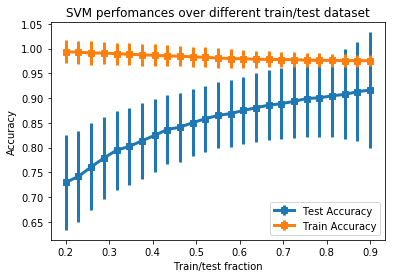

In [140]:
reducer = SelectKBest(f_classif, k=31)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)


performance_assesment_fraction(feature_dataset_reduced, labels, 2000, par_fine)

In [42]:
C_parameters= np.logspace(-6, 3, 100)
k_fold = 5 # number of k sub-folders to divide the set
seed = 1
max_iters = 100
kernel_types=['linear', 'rbf', 'sigmoid']

best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels, feature_dataset_full, C_parameters, kernel_types, k_fold, seed, max_iters)

--- Fold 0 ---


/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.8666666666666666 Penalty parameter= 6.579332246575683e-05 kernel type= linear
Corresponding accuracy train = 0.95


In [43]:
C_param_sophisticated = np.linspace(1e-5,1e-4,1000)
kernel_types_reasonable = ['linear']
k_fold = 5
max_iters = 100

best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels, feature_dataset_full, C_param_sophisticated, kernel_types_reasonable, k_fold, seed, max_iters)

--- Fold 0 ---


/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9 Penalty parameter= 9.18018018018018e-05 kernel type= linear
Corresponding accuracy train = 0.9666666666666666


In [11]:
from sklearn import svm

def classification_SVM_experiments(X, Y, best_C_input, best_kernel_type, fraction_train_test, num_experiments):
    
    best_C=best_C_input
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    best_kernel_type=best_kernel_type
    dataset_length=X.shape[0];
    
    
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        train=X[i1,:]
        labels_train=Y[i1]
        
        test= X[i2,:]
        labels_test=Y[i2]

        #SVM classifier definition
        clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train
    #return [np.mean(svm_total_acc_test), np.std(svm_total_acc_test), np.mean(svm_total_acc_train), np.std(svm_total_acc_train)]

In [45]:
num_experiment = 500

fracs = np.linspace(0.2,0.9,20)
accuracy_test_mean  = []
accuracy_test_std   = []
accuracy_train_mean = []
accuracy_train_std  = []

for frac_tr_te in fracs:
    acc_test, acc_train = classification_SVM_experiments(feature_dataset_full, labels, best_C, best_kernel_type, frac_tr_te, num_experiment)
    #saving of metrics of interest
    accuracy_test_mean.append(np.mean(acc_test))
    accuracy_test_std.append(np.std(acc_test))
    accuracy_train_mean.append(np.mean(acc_train))
    accuracy_train_std.append(np.std(acc_train))
    

print(np.mean(acc_test))
print(np.mean(acc_train))

0.8073333333333332
0.9744074074074074


In [46]:
print(np.mean(acc_test))
print(np.mean(acc_train))

0.8073333333333332
0.9744074074074074


## Results plotting
wow

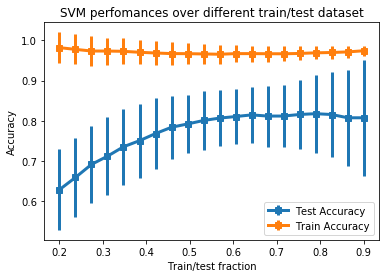

In [47]:
#plt.plot(fracs, accuracy_test_mean)
#plt.plot(fracs, accuracy_train_mean
plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.title('SVM perfomances over different train/test dataset')
plt.ylabel('Accuracy')
plt.xlabel('Train/test fraction')
plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
plt.savefig('train_test_acc', format='pdf')
plt.show()

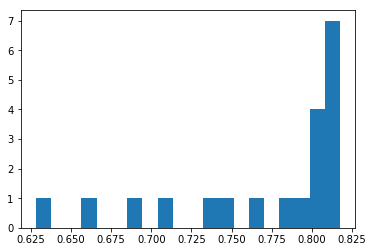

In [28]:
plt.hist(accuracy_test_mean, bins=20, alpha=1)
plt.show()

In [55]:
fracs = np.linspace(0.4,0.9,10)
plt.plot(fracs,accuracy)
plt.show()

NameError: name 'accuracy' is not defined

In [101]:
def leave_one_out(X,y,clf):
    for i in range(60):
#SVM classifier definition
        i1 = [j for j in range(60)]
        i1.remove(i)
        i2 = i
        train=X[i1,:]
        labels_train=Y[i1]

        test= X[i2,:]
        labels_test=Y[i2]
        #print(i1)
        #print(i2)
        clf_temp = clf
        #SVM fit on train data
        clf_temp.fit(train, labels_train)  

        #Accuracy on test
        predicted_labels_test = clf_temp.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)

    return(np.mean(svm_total_acc_test))

In [95]:
##Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#feature_dataset_full
def choose_k_feat(k, num_experiment=300):
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    boolean_vec = reducer.get_support()
    idx =[]
    for i in range(len(boolean_vec)): 
        if boolean_vec[i] == True: idx.append(i)
    
    print("index of features retained:")
    print(idx)

    #hyperparameters tune 1
    C_parameters= np.logspace(-6, 3, 100)
    k_fold = 5 # number of k sub-folders to divide the set
    seed = 1
    max_iters = 100
    kernel_types=['linear', 'rbf', 'sigmoid']

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            cross_validation_SVM(labels, feature_dataset_reduced, C_parameters, kernel_types, k_fold, seed, max_iters)

    #hyperparameters tune 2
    C_param_sophisticated = np.linspace(best_C/10,best_C*10,1000)
    kernel_types_reasonable = [best_kernel_type]
    k_fold = 5
    max_iters = 100

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            cross_validation_SVM(labels, feature_dataset_reduced, C_param_sophisticated, kernel_types_reasonable, k_fold, seed, max_iters)
        
    test_eval = leave_one_out(labels, feature_dataset_reduced, C_param_sophisticated, kernel_types_reasonable, k_fold, seed, max_iters)
    return test_eval


In [96]:
for k in [2,5,10,15,20,50]:
    print(choose_k_feat(k))

index of features retained:
[288, 292]


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


NameError: name 'cross_validation_SVM' is not defined

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


index of features retained:
[11, 14, 18, 39, 45, 46, 58, 66, 67, 70, 71, 74, 82, 93, 106, 110, 115, 118, 119, 120, 122, 128, 136, 139, 143, 158, 161, 165, 169, 173, 192, 193, 201, 213, 214, 217, 218, 228, 236, 240, 244, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 340, 354, 358]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9166666666666667 Penalty parameter= 0.008111308307896872 kernel type= linear
Corresponding accuracy train = 0.9291666666666666
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9166666666666667 Penalty parameter= 0.012225422341541864 kernel type= linear
Corresponding accuracy train = 0.8916666666666666
mean of test and train accuracy
0.8966666666666666
0.9804320987654322


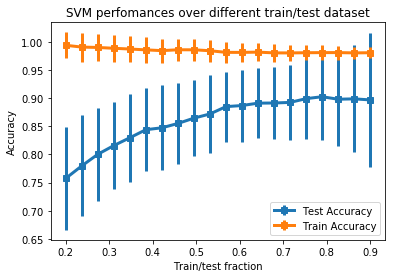

index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 98, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 128, 134, 136, 139, 140, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 181, 189, 192, 193, 197, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.012328467394420659 kernel type= linear
Corresponding accuracy train = 0.9833333333333332
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.011739810843155526 kernel type= linear
Corresponding accuracy train = 0.9791666666666666
mean of test and train accuracy
0.9083333333333333
0.9973456790123456


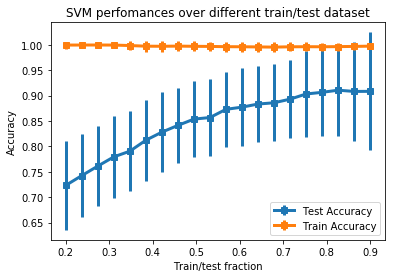

index of features retained:
[3, 5, 7, 11, 14, 15, 18, 22, 26, 29, 35, 37, 39, 40, 42, 44, 45, 46, 49, 51, 52, 54, 55, 58, 61, 62, 63, 66, 67, 70, 71, 74, 76, 78, 82, 83, 86, 88, 92, 93, 96, 97, 98, 100, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 126, 128, 132, 133, 134, 136, 139, 140, 143, 144, 145, 149, 153, 158, 160, 161, 164, 165, 168, 169, 172, 173, 175, 181, 185, 189, 190, 192, 193, 197, 200, 201, 212, 213, 214, 216, 217, 218, 222, 224, 226, 227, 228, 230, 231, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 265, 267, 268, 272, 276, 280, 282, 284, 287, 288, 289, 291, 292, 293, 296, 300, 304, 307, 310, 312, 316, 320, 322, 326, 336, 340, 352, 354, 356, 357, 358, 366, 368, 369, 370, 374, 375, 377, 381]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.8833333333333334 Penalty parameter= 0.0003511191734215131 kernel type= linear
Corresponding accuracy train = 0.9291666666666666
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 

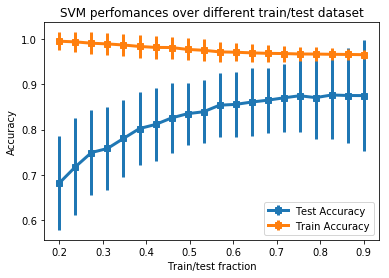

index of features retained:
[3, 5, 7, 11, 14, 15, 18, 22, 26, 28, 29, 32, 33, 35, 37, 39, 40, 42, 44, 45, 46, 48, 49, 51, 52, 54, 55, 56, 58, 59, 61, 62, 63, 66, 67, 70, 71, 74, 76, 78, 80, 82, 83, 86, 88, 89, 91, 92, 93, 96, 97, 98, 99, 100, 101, 106, 107, 108, 110, 111, 112, 115, 118, 119, 120, 121, 122, 123, 124, 126, 128, 132, 133, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 149, 153, 158, 160, 161, 164, 165, 166, 168, 169, 171, 172, 173, 174, 175, 179, 181, 185, 189, 190, 191, 192, 193, 197, 200, 201, 212, 213, 214, 216, 217, 218, 222, 223, 224, 225, 226, 227, 228, 230, 231, 233, 236, 237, 240, 244, 247, 248, 252, 255, 256, 257, 258, 260, 261, 262, 263, 265, 267, 268, 271, 272, 273, 274, 276, 280, 281, 282, 283, 284, 287, 288, 289, 291, 292, 293, 296, 298, 300, 304, 307, 310, 312, 314, 316, 318, 320, 322, 326, 328, 330, 332, 336, 340, 342, 344, 346, 352, 354, 356, 357, 358, 359, 361, 362, 365, 366, 368, 369, 370, 373, 374, 375, 376, 377, 381, 382]
--- Fold 0 ---
--- Fold 1 -

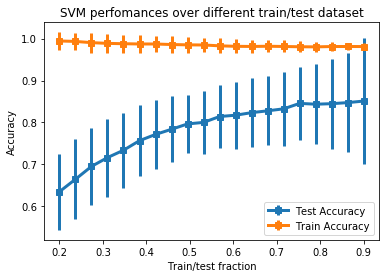

index of features retained:
[1, 3, 5, 7, 11, 14, 15, 18, 22, 26, 28, 29, 30, 32, 33, 35, 36, 37, 39, 40, 42, 44, 45, 46, 48, 49, 51, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 66, 67, 70, 71, 72, 73, 74, 75, 76, 78, 80, 82, 83, 84, 86, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 106, 107, 108, 110, 111, 112, 115, 118, 119, 120, 121, 122, 123, 124, 126, 128, 129, 132, 133, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 149, 150, 153, 154, 156, 158, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 185, 189, 190, 191, 192, 193, 195, 197, 200, 201, 205, 206, 208, 209, 210, 212, 213, 214, 216, 217, 218, 219, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 236, 237, 240, 244, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 267, 268, 270, 271, 272, 273, 274, 275, 276, 277, 280, 281, 282, 283, 284, 285, 287, 288, 289, 290, 291, 292, 293, 296, 298, 299, 300, 303, 304, 307, 310, 312, 314, 316, 31

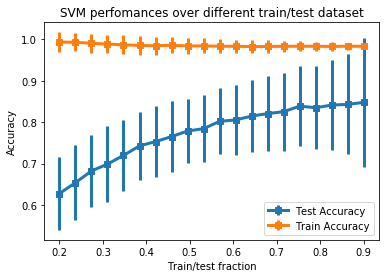

index of features retained:
[1, 2, 3, 5, 7, 10, 11, 14, 15, 16, 18, 20, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 106, 107, 108, 110, 111, 112, 113, 115, 118, 119, 120, 121, 122, 123, 124, 126, 128, 129, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 153, 154, 155, 156, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 181, 185, 186, 189, 190, 191, 192, 193, 195, 197, 200, 201, 203, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 235, 236, 237, 240, 241, 244, 245, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 270, 271,

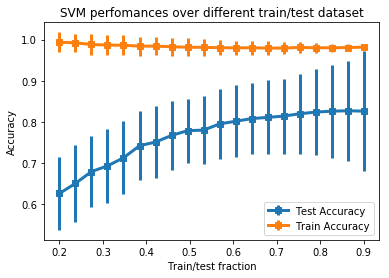

In [59]:
for k in [60, 100, 150, 200, 250, 300]:
    choose_k_feat(k)

In [65]:
a = [3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 98, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 128, 134, 136, 139, 140, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 181, 189, 192, 193, 197, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]
len(a)

100

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


index of features retained:
[3, 11, 14, 18, 22, 26, 29, 35, 39, 45, 46, 51, 58, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 106, 110, 115, 118, 119, 120, 122, 128, 136, 139, 143, 158, 161, 164, 165, 168, 169, 172, 173, 189, 192, 193, 201, 212, 213, 214, 217, 218, 224, 228, 230, 236, 240, 244, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9166666666666667 Penalty parameter= 0.012328467394420659 kernel type= linear
Corresponding accuracy train = 0.9583333333333333
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.0035541527623555048 kernel type= linear
Corresponding accuracy train = 0.95
mean of test and train accuracy
0.9133333333333333
0.9624074074074076


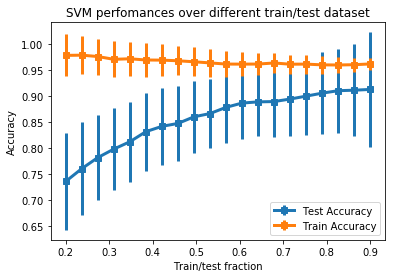

index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 101, 106, 110, 111, 115, 118, 119, 120, 122, 128, 134, 136, 139, 143, 158, 161, 164, 165, 168, 169, 172, 173, 189, 192, 193, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 369]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9333333333333333 Penalty parameter= 0.004328761281083062 kernel type= linear
Corresponding accuracy train = 0.95
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.0034786081646180993 kernel type= linear
Corresponding accuracy train = 0.9541666666666666
mean of test and train accuracy
0.9077777777777777
0.9643209876543211


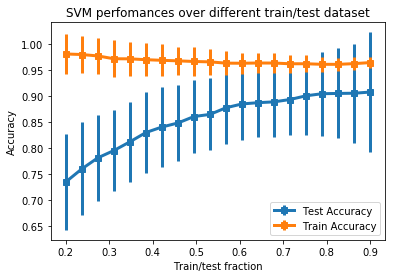

index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 98, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 128, 134, 136, 139, 140, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 181, 189, 192, 193, 197, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.012328467394420659 kernel type= linear
Corresponding accuracy train = 0.9833333333333332
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.011739810843155526 kernel type= linear
Corresponding accuracy train = 0.9791666666666666
mean of test and train accuracy
0.9083333333333333
0.9973456790123456


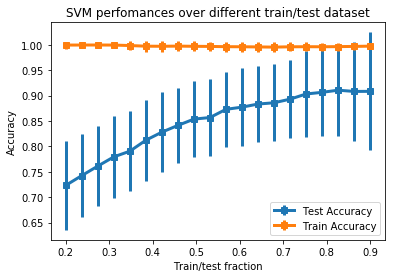

index of features retained:
[3, 5, 7, 11, 14, 15, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 98, 100, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 126, 128, 134, 136, 139, 140, 143, 149, 153, 158, 161, 164, 165, 168, 169, 172, 173, 181, 185, 189, 192, 193, 197, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 268, 272, 276, 280, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 356, 358, 368, 369, 377]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9 Penalty parameter= 0.0015199110829529348 kernel type= linear
Corresponding accuracy train = 0.9416666666666667
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9166666666666666 Penalty parameter= 0.0014624009338682293 kernel type= linear
Corresponding accuracy train = 0.9291666666666668
mean of test and tra

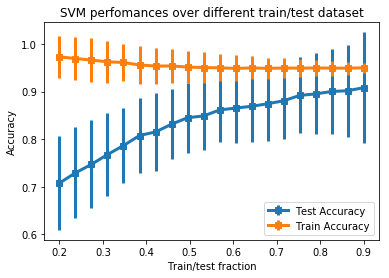

index of features retained:
[3, 5, 7, 11, 14, 15, 18, 22, 26, 29, 35, 39, 40, 42, 45, 46, 51, 55, 58, 62, 63, 66, 67, 70, 71, 74, 76, 78, 82, 83, 88, 92, 93, 96, 97, 98, 100, 101, 106, 107, 110, 111, 115, 118, 119, 120, 121, 122, 123, 126, 128, 132, 134, 136, 139, 140, 143, 149, 153, 158, 161, 164, 165, 168, 169, 172, 173, 181, 185, 189, 190, 192, 193, 197, 201, 212, 213, 214, 216, 217, 218, 222, 224, 228, 230, 231, 236, 240, 244, 247, 248, 252, 256, 260, 262, 263, 268, 272, 276, 280, 284, 287, 288, 291, 292, 304, 310, 312, 316, 320, 336, 340, 354, 356, 358, 368, 369, 370, 377, 381]
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.9 Penalty parameter= 0.0023101297000831605 kernel type= linear
Corresponding accuracy train = 0.8916666666666666
--- Fold 0 ---
--- Fold 1 ---
--- Fold 2 ---
--- Fold 3 ---
--- Fold 4 ---
Best accuracy test = 0.95 Penalty parameter= 0.0050385801836948935 kernel type= linear
Corresponding accuracy train = 0.9
me

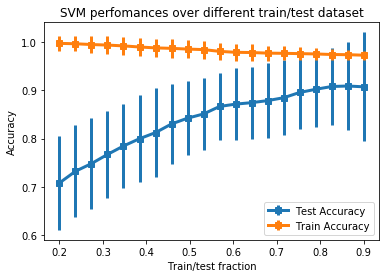

In [66]:
for k in [80,90,100,110,120]:
    choose_k_feat(k)

In [8]:
##Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#feature_dataset_full
def performance_tuning_k(k, num_experiment=300):
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    boolean_vec = reducer.get_support()
    idx =[]
    for i in range(len(boolean_vec)): 
        if boolean_vec[i] == True: idx.append(i)
    
    #print("index of features retained:")
    #print(idx)

    #hyperparameters tune 1
    C_parameters= np.logspace(-6, 3, 100)
    k_fold = 5 # number of k sub-folders to divide the set
    seed = 1
    max_iters = 100
    kernel_types=['linear', 'rbf', 'sigmoid']

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            cross_validation_SVM(labels, feature_dataset_reduced, C_parameters, kernel_types, k_fold, seed, max_iters)

    #hyperparameters tune 2
    C_param_sophisticated = np.linspace(best_C/10,best_C*10,1000)
    kernel_types_reasonable = [best_kernel_type]
    k_fold = 5
    max_iters = 100

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            cross_validation_SVM(labels, feature_dataset_reduced, C_param_sophisticated, kernel_types_reasonable, k_fold, seed, max_iters)

    #performances assessment

    acc_test, acc_train = classification_SVM_experiments(feature_dataset_reduced, labels, best_C, best_kernel_type, 0.7, num_experiment)
        #saving of metrics of interest
    return [np.mean(acc_test), np.std(acc_test)]

progress: 1.4285714285714164%    --  k=50


/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.8653703703703702
progress: 2.857142857142861%    --  k=51
0.8653703703703702
progress: 4.285714285714278%    --  k=52
0.8740740740740741
progress: 5.714285714285722%    --  k=53
0.8601851851851852
progress: 7.142857142857139%    --  k=54
0.8675925925925926
progress: 8.57142857142857%    --  k=55
0.8753703703703702
progress: 10.0%    --  k=56
0.865
progress: 11.42857142857143%    --  k=57
0.8912962962962964
progress: 12.857142857142861%    --  k=58
0.8896296296296295
progress: 14.285714285714292%    --  k=59
0.8642592592592593
progress: 15.714285714285708%    --  k=60
0.8922222222222221
progress: 17.14285714285714%    --  k=61
0.8996296296296297
progress: 18.57142857142857%    --  k=62
0.8959259259259261
progress: 20.0%    --  k=63
0.8803703703703702
progress: 21.42857142857143%    --  k=64
0.8968518518518518
progress: 22.857142857142847%    --  k=65
0.8979629629629631
progress: 24.285714285714292%    --  k=66
0.8981481481481481
progress: 25.714285714285708%    --  k=67
0.886296296296

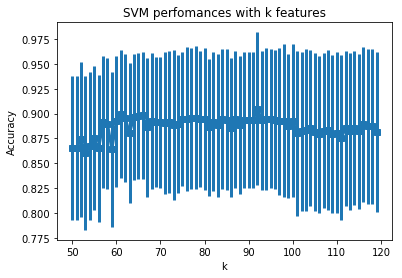

In [8]:
experiments = np.arange(50,120)
k_mean_perf = []
k_std_perf = []
for k in experiments:
    print("progress: " + str(100-(experiments[-1]-k)/len(experiments)*100) + "%    --  k=" + str(k))
    [meanAcc, stdAcc] = performance_tuning_k(k, num_experiment=300)
    print(meanAcc)
    k_mean_perf.append(meanAcc)
    k_std_perf.append(stdAcc)
    
plt.errorbar(experiments, k_mean_perf, yerr=k_std_perf, label="Error bars plot", fmt="s-",  linewidth=3)
plt.title('SVM perfomances with k features')
plt.ylabel('Accuracy')
plt.xlabel('k')
#plt.legend('Test Accuracy', loc=4)
plt.show()


# best k = 92

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 101, 106, 110, 111, 115, 118, 119, 120, 122, 128, 134, 136, 139, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 189, 192, 193, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]
mean of test and train accuracy
0.931
0.9989012345679011


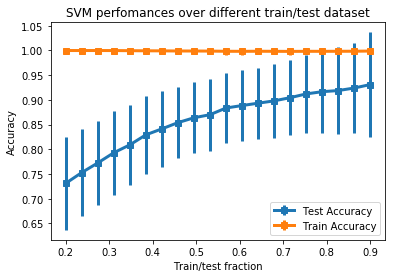

In [11]:
choose_k_feat(k=92, num_experiment = 1500)

In [9]:
def hyper_SVM_multiple_executions(X, Y, C_parameters, kernel_types, max_iters, fraction_train_test, num_experiments):
    
    accuracies_train = np.zeros([len(C_parameters),len(kernel_types)])
    accuracies_test = np.zeros([len(C_parameters),len(kernel_types)])
    svm_total_acc_test = []
    svm_total_acc_train = []
    seed=np.arange(num_experiments, dtype = 'int64')
    # For each degree, compute the least squares weights, the predictions and the accuracies
    #print(num_experiments)
    #print(seed)
        
        
    for C_id, single_C in enumerate(C_parameters):
                
        #print('>> Penalty parameter C', single_C, '<<')
                
        for kernel_id, single_kernel in enumerate(kernel_types):
            #print('>> Type of Kernel ',single_kernel, '<')
            # Compute the best weights on the training set
                for single_seed in seed:
                    [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
                    #print(seed)
                    #print(i2)
                    train=X[i1,:]
                    labels_train=Y[i1]

                    test= X[i2,:]
                    labels_test=Y[i2]

                    #SVM classifier definition
                    clf = svm.SVC(C=single_C, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel=single_kernel,
        max_iter=max_iters, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
                    #SVM fit on train data
                    clf.fit(train, labels_train)  


                    #Accuracy on test
                    predicted_labels_test = clf.predict(test)
                    SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
                    svm_total_acc_test.append(SVM_accuracy_test)


                    #Accuracy on train
                    predicted_labels_train = clf.predict(train)
                    SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
                    svm_total_acc_train.append(SVM_accuracy_train)

                
    


         
                # Compute the accuracies for each degree
                accuracies_train[C_id,kernel_id] = np.mean(svm_total_acc_train)
                accuracies_test[C_id,kernel_id] = np.mean(svm_total_acc_test)
            #print(accuracies_test[C_id,kernel_id],accuracies_train[C_id,kernel_id])
        
        
    return accuracies_train, accuracies_test



def tuning_SVM(X, Y, C_parameters, kernel_types, max_iters, fraction_train_test, num_experiments):
    
    
    # Initialize matrix of computed accuracies for each degree and each fold
    accuracies_train_by_fold = np.zeros([len(C_parameters), len(kernel_types)])
    accuracies_test_by_fold = np.zeros([len(C_parameters), len(kernel_types)])
    
       
    # Compute the accuracies for each degree
    accuracies_train, accuracies_test =  hyper_SVM_multiple_executions(X, Y, C_parameters, kernel_types, max_iters, fraction_train_test, num_experiments)
    
    # Get the index of the best accuracy in the testing set
    max_id_C_parameter, max_id_kernel= \
        np.unravel_index(accuracies_test.argmax(), accuracies_test.shape)
    
    # Find the optimal degree and the corresponding accuracies in the training and testing sets
    best_C_parameter=C_parameters[max_id_C_parameter]
    best_kernel_type=kernel_types[max_id_kernel]
    best_accuracy_test = accuracies_test[max_id_C_parameter,max_id_kernel]
    corresponding_accuracy_train = accuracies_train[max_id_C_parameter,max_id_kernel]
    
    print('Best accuracy test =', best_accuracy_test , 'Penalty parameter=',best_C_parameter, 'kernel type=',best_kernel_type)
    print('Corresponding accuracy train =', corresponding_accuracy_train)
    
    return best_C_parameter, best_kernel_type, best_accuracy_test, corresponding_accuracy_train


def performance_tuning_k_new(k, num_experiments_hyper=3, num_experiments_final=500, fraction_train_test=0.7):
    reducer = SelectKBest(f_classif, k)
    feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

    boolean_vec = reducer.get_support()
    idx =[]
    for i in range(len(boolean_vec)): 
        if boolean_vec[i] == True: idx.append(i)
    
    #print("index of features retained:")
    #print(idx)

    #hyperparameters tune 1
    C_parameters= np.logspace(-3, 4, 2000)
    k_fold = 5 # number of k sub-folders to divide the set
    seed = 1
    max_iters = 100
    kernel_types=['linear', 'rbf', 'sigmoid']

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            tuning_SVM(feature_dataset_reduced, labels, C_parameters, kernel_types, max_iters, fraction_train_test, num_experiments = num_experiments_hyper)

    #hyperparameters tune 2
    C_param_sophisticated = np.linspace(best_C/10,best_C*10,1000)
    kernel_types_reasonable = [best_kernel_type]
    k_fold = 5
    max_iters = 100

    best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
            tuning_SVM(feature_dataset_reduced, labels, C_param_sophisticated, kernel_types_reasonable, max_iters, fraction_train_test, num_experiments = num_experiments_hyper)

    #performances assessment
    acc_test, acc_train = classification_SVM_experiments(feature_dataset_reduced, labels, best_C, best_kernel_type, fraction_train_test, num_experiments = num_experiments_final)
        #saving of metrics of interest
    return [np.mean(acc_test), np.std(acc_test)]


In [54]:
performance_tuning_k_new(92, num_experiments_hyper=50, num_experiments_final=500, fraction_train_test=0.7)

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


50
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best accuracy test = 0.5223586094433327 Penalty parameter= 100.0 kernel type= linear
Corresponding accuracy train = 0.6978696909050479
50
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Best accuracy test = 0.8133333333333336 Penalty parameter= 73.42342342342343 kernel type= linear
Corresponding accuracy train = 0.9109523809523811


[0.9062222222222223, 0.07798891975747754]

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 101, 106, 110, 111, 115, 118, 119, 120, 122, 128, 134, 136, 139, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 189, 192, 193, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]
mean of test and train accuracy
0.9464444444444445
1.0


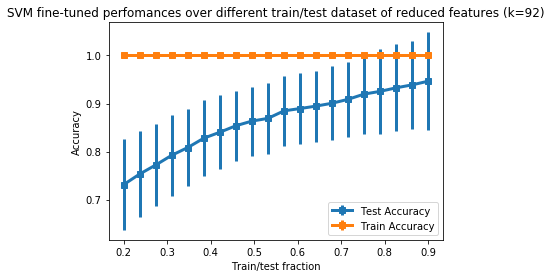

In [13]:
#best Values
best_C = 73.42342342342343
best_kernel_type = 'linear'
k = 92

#feature selection
reducer = SelectKBest(f_classif, k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print("index of features retained:")
print(idx)


#performances assessment
num_experiment = 1500
fracs = np.linspace(0.2,0.9,20)
accuracy_test_mean  = []
accuracy_test_std   = []
accuracy_train_mean = []
accuracy_train_std  = []

for frac_tr_te in fracs:
    acc_test, acc_train = classification_SVM_experiments(feature_dataset_reduced, labels, best_C, best_kernel_type, frac_tr_te, num_experiment)
    #saving of metrics of interest
    accuracy_test_mean.append(np.mean(acc_test))
    accuracy_test_std.append(np.std(acc_test))
    accuracy_train_mean.append(np.mean(acc_train))
    accuracy_train_std.append(np.std(acc_train))

print("mean of test and train accuracy")
print(np.mean(acc_test))
print(np.mean(acc_train))

plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.title('SVM fine-tuned perfomances over different train/test dataset of reduced features (k=92)')
plt.ylabel('Accuracy')
plt.xlabel('Train/test fraction')
plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
plt.savefig('train_test_acc_fine_tuned', format='pdf')
plt.show()

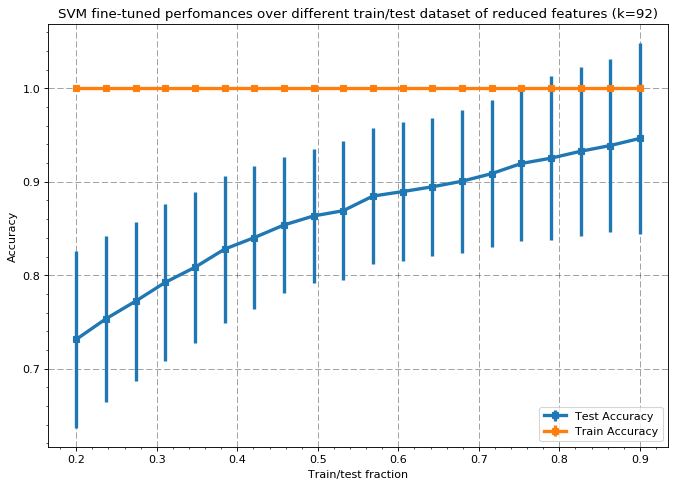

In [14]:
plt.figure(figsize=(10, 7), dpi=80)
#plt.grid(b=True, which='major', color='k', linestyle='--')
plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.grid(b=True, which='major', color='k', linestyle='--', alpha = 0.4)
#plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
plt.minorticks_on()
plt.title('SVM fine-tuned perfomances over different train/test dataset of reduced features (k=92)')
plt.ylabel('Accuracy')
plt.xlabel('Train/test fraction')

plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
plt.savefig('train_test_acc_fine_tuned2.eps', format='eps')
plt.show()

In [84]:
0.2*60

12.0

# Leave one out cross validation

In [15]:
##Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


#best Values
best_C = 73.42342342342343
best_kernel_type = 'linear'
k = 92

#feature selection
reducer = SelectKBest(f_classif, k)
feature_dataset_reduced = reducer.fit_transform(feature_dataset_full, labels)

X = feature_dataset_reduced
Y = labels

boolean_vec = reducer.get_support()
idx =[]
for i in range(len(boolean_vec)): 
    if boolean_vec[i] == True: idx.append(i)
print("index of features retained:")
print(idx)

svm_total_acc_test = []
#performances assessment with leave one out
for i in range(60):
#SVM classifier definition
    i1 = [j for j in range(60)]
    i1.remove(i)
    i2 = i
    train=X[i1,:]
    labels_train=Y[i1]

    test= X[i2,:]
    labels_test=Y[i2]
    #print(i1)
    #print(i2)
    clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    #SVM fit on train data
    clf.fit(train, labels_train)  

    #Accuracy on test
    predicted_labels_test = clf.predict(test)
    SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
    svm_total_acc_test.append(SVM_accuracy_test)


print("mean of test accuracy")
print(np.mean(svm_total_acc_test))






/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/va

index of features retained:
[3, 7, 11, 14, 18, 22, 26, 29, 35, 39, 40, 45, 46, 51, 55, 58, 62, 66, 67, 70, 71, 74, 78, 82, 83, 88, 92, 93, 96, 97, 101, 106, 110, 111, 115, 118, 119, 120, 122, 128, 134, 136, 139, 143, 149, 158, 161, 164, 165, 168, 169, 172, 173, 189, 192, 193, 201, 212, 213, 214, 216, 217, 218, 224, 228, 230, 236, 240, 244, 247, 248, 256, 260, 262, 263, 272, 276, 284, 287, 288, 291, 292, 304, 312, 316, 320, 336, 340, 354, 358, 368, 369]


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

mean of test accuracy
0.9666666666666667


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/

In [34]:
a = [i for i in range(60)]
j = a.remove(0)

In [7]:
print(svm_total_acc_test)
print(np.mean(svm_total_acc_test))
print(np.std(svm_total_acc_test))

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.9666666666666667
0.17950549357115012


In [24]:
print(i1)

None


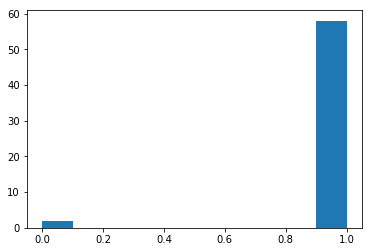

In [12]:
plt.hist(svm_total_acc_test)
plt.show()